In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import pandas as pd
import numpy as np
np.random.seed(42)
torch.manual_seed(42)

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Fraud Analytics/Payments.csv')

# Create a new column with sorted tuples of Sender and Receiver
df['Transaction_Pair'] = df.apply(lambda x: tuple(sorted([x['Sender'], x['Receiver']])), axis=1)

# Now, group by this new column and sum the amounts
df_grouped = df.groupby('Transaction_Pair', as_index=False)['Amount'].sum()

# If needed, split the Transaction_Pair back into Sender and Receiver, though they will not be in original order
df_grouped[['Sender', 'Receiver']] = pd.DataFrame(df_grouped['Transaction_Pair'].tolist(), index=df_grouped.index)

print(df_grouped)

     Transaction_Pair   Amount  Sender  Receiver
0        (1001, 1007)  1907741    1001      1007
1        (1001, 1021)   291532    1001      1021
2        (1001, 1035)    51404    1001      1035
3        (1001, 1037)  3849579    1001      1037
4        (1001, 1049)   100541    1001      1049
...               ...      ...     ...       ...
5035     (1845, 1990)    27381    1845      1990
5036     (1845, 1991)   260843    1845      1991
5037     (1845, 2054)   120571    1845      2054
5038     (1845, 2085)   489474    1845      2085
5039     (1845, 2126)    94999    1845      2126

[5040 rows x 4 columns]


In [4]:
# Step 1: Identify unique nodes
nodes = pd.concat([df_grouped['Sender'], df_grouped['Receiver']]).unique()
nodes.sort()  # Optional, but keeps nodes in a consistent order

# Step 2: Initialize the matrix
N = len(nodes)  # Number of unique nodes
adj_matrix = np.zeros((N, N), dtype=np.float64)  # Using float to accommodate amounts

# Step 3: Map nodes to indices
node_index = {node: idx for idx, node in enumerate(nodes)}

# Step 4: Fill the matrix
for _, row in df_grouped.iterrows():
    sender_idx = node_index[row['Sender']]
    receiver_idx = node_index[row['Receiver']]
    adj_matrix[sender_idx, receiver_idx] = row['Amount']
    adj_matrix[receiver_idx, sender_idx] = row['Amount']

print(adj_matrix)

[[     0.      0.      0. ...      0.      0.      0.]
 [     0.      0. 144680. ...      0.      0. 475689.]
 [     0. 144680.      0. ...      0.      0.      0.]
 ...
 [     0.      0.      0. ...      0.      0.      0.]
 [     0.      0.      0. ...      0.      0.      0.]
 [     0. 475689.      0. ...      0.      0.      0.]]


In [5]:
import networkx as nx

# Create the graph from the adjacency matrix
G = nx.from_numpy_array(adj_matrix)

# Check if the graph is connected
is_connected = nx.is_connected(G)

print("Is the graph connected?", is_connected)

Is the graph connected? False


In [6]:
def degree_matrix(W):
  D = np.zeros_like(W)
  for i in range(len(W)):
    D[i,i] = np.sum(W[i])
  return D

D = degree_matrix(adj_matrix)

In [7]:
L = D - adj_matrix

eigen_vals,eigen_vecs = np.linalg.eigh(L)
sorted_indx = np.argsort(eigen_vals)
eigen_vals = eigen_vals[sorted_indx]
eigen_vecs = eigen_vecs[:,sorted_indx]

In [8]:
import networkx as nx

G = nx.Graph()

for index,row in df.iterrows():
  G.add_edge(row['Sender'],row['Receiver'],weight= row['Amount'])

print(G.number_of_nodes())

799


In [9]:
# import matplotlib.pyplot as plt

# # Visualize the Directed graph
# pos = nx.spring_layout(G, seed=42, k=0.9)
# labels = nx.get_edge_attributes(G, 'label')

# plt.figure(figsize=(12, 10))

# nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')

# plt.title('Undirected Graph')
# plt.show()

In [10]:
# matrix = nx.laplacian_matrix(G).toarray()

# eigen_vals,eigen_vecs = np.linalg.eig(matrix)
# sorted_indx = np.argsort(eigen_vals)
# eigen_vals = eigen_vals[sorted_indx]
# eigen_vecs = eigen_vecs[:,sorted_indx]

# print(eigen_vals)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 0 1 1 1 1 0 9 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1
 0 0 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 4 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 0 1 1 1 5 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 4 1 1 0 0 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 

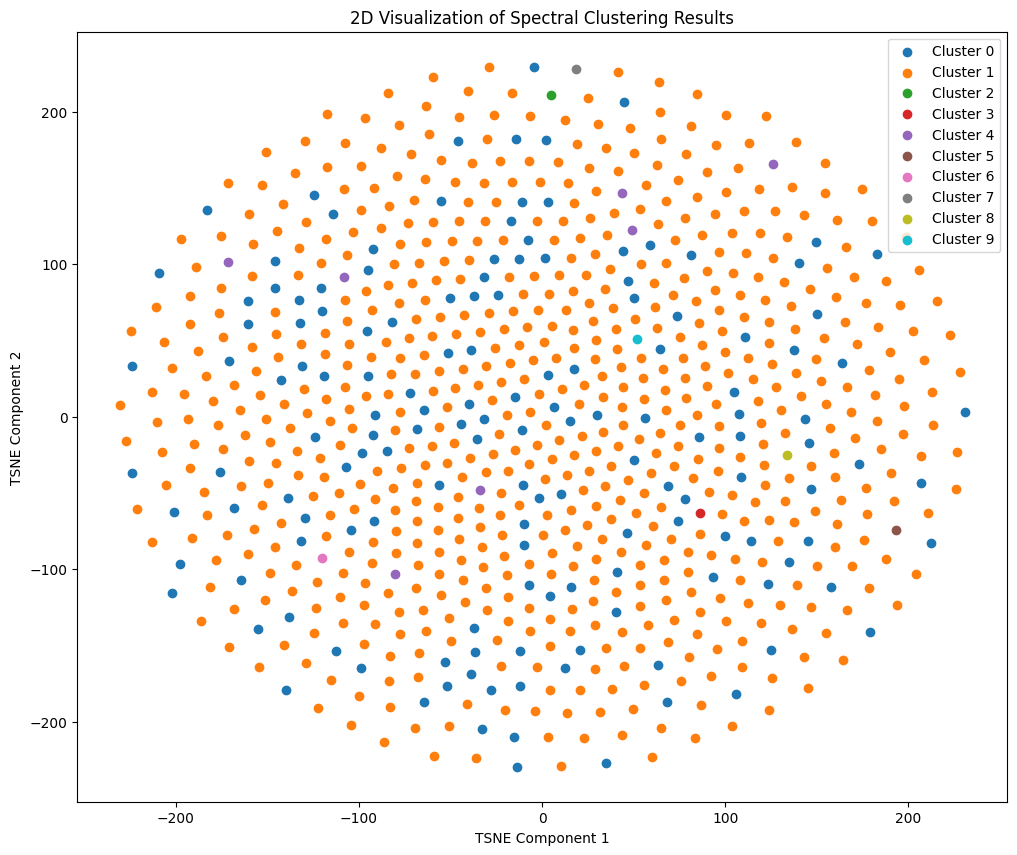

In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

"""kmeans = KMeans(n_clusters=k)
kmeans.fit_predict(U)"""

class K_Means:

    def __init__(self, k=2, tolerance = 0.001, max_iter = 500):
        self.k = k
        self.max_iterations = max_iter
        self.tolerance = tolerance

    def euclidean_distance(self, point1, point2):
        # return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)   #sqrt((x1-x2)^2 + (y1-y2)^2)
        return np.linalg.norm(point1-point2, axis=0)

    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

    def fit_predict(self, data):
        self.fit(data)
        labels = []
        for point in data:
            labels.append(self.predict(point))
        return np.array(labels)

    def fit(self, data):
        self.centroids = {}
        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.max_iterations):
            self.classes = {}
            for j in range(self.k):
                self.classes[j] = []

            for point in data:
                distances = []
                for index in self.centroids:
                    distances.append(self.euclidean_distance(point,self.centroids[index]))
                cluster_index = distances.index(min(distances))
                self.classes[cluster_index].append(point)

            previous = dict(self.centroids)
            for cluster_index in self.classes:
                self.centroids[cluster_index] = np.average(self.classes[cluster_index], axis = 0)

            isOptimal = True

            for centroid in self.centroids:
                original_centroid = previous[centroid]
                curr = self.centroids[centroid]
                if np.sum((curr - original_centroid)/(original_centroid +  1e-10) * 100.0) > self.tolerance:
                    isOptimal = False
            if isOptimal:
                break

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Decide the number of clusters k
k = 10  # You will choose this based on your specific data and needs

U = eigen_vecs
# Perform k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(U)

print(labels)

# For plotting, we will use a dimensionality reduction technique to project the data to 2D
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
U_tsne = tsne.fit_transform(U)

# Plotting
plt.figure(figsize=(12, 10))
for cluster_index in range(k):
    plt.scatter(U_tsne[labels == cluster_index, 0],
                U_tsne[labels == cluster_index, 1],
                label=f'Cluster {cluster_index}')

plt.title('2D Visualization of Spectral Clustering Results')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.legend()
plt.savefig('spectral_clustering.png')
plt.show()

The above numpy array shows the cluster associated with each node.